In [183]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [184]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

In [185]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

In [186]:
test_dataset = MNIST(root='data/', train=False)
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 0


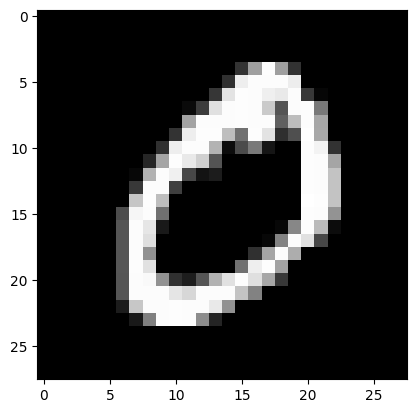

In [188]:
image, label = dataset[1]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


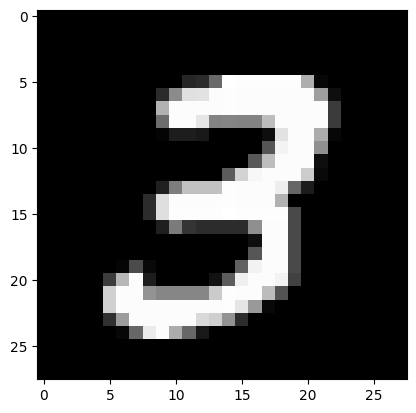

In [189]:
image, label = dataset[7]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 8


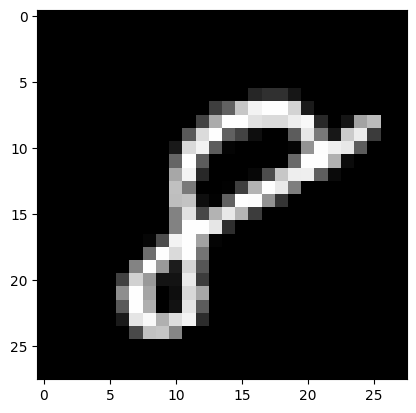

In [190]:
image, label = dataset[-1]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [191]:
import torchvision.transforms as transforms

In [192]:
# MNIST dataset (Images converted into Pytorch Tensors)
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

In [193]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


## Training and Validation

In [194]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [195]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [196]:
import torch.nn as nn
import torch.nn.functional as F

In [197]:
input_size = 28*28
num_classes = 10

## Training the Model

In [198]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [199]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [200]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [201]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [202]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.2910475730895996, 'val_acc': 0.16782040894031525}

In [203]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9363, val_acc: 0.6037
Epoch [1], val_loss: 1.6737, val_acc: 0.7060
Epoch [2], val_loss: 1.4774, val_acc: 0.7470
Epoch [3], val_loss: 1.3287, val_acc: 0.7714
Epoch [4], val_loss: 1.2142, val_acc: 0.7863


In [204]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1240, val_acc: 0.7953
Epoch [1], val_loss: 1.0514, val_acc: 0.8070
Epoch [2], val_loss: 0.9920, val_acc: 0.8134
Epoch [3], val_loss: 0.9424, val_acc: 0.8188
Epoch [4], val_loss: 0.9004, val_acc: 0.8242


In [205]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8644, val_acc: 0.8273
Epoch [1], val_loss: 0.8332, val_acc: 0.8322
Epoch [2], val_loss: 0.8058, val_acc: 0.8347
Epoch [3], val_loss: 0.7816, val_acc: 0.8361
Epoch [4], val_loss: 0.7601, val_acc: 0.8390


In [206]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7407, val_acc: 0.8414
Epoch [1], val_loss: 0.7233, val_acc: 0.8442
Epoch [2], val_loss: 0.7074, val_acc: 0.8464
Epoch [3], val_loss: 0.6929, val_acc: 0.8488
Epoch [4], val_loss: 0.6796, val_acc: 0.8513


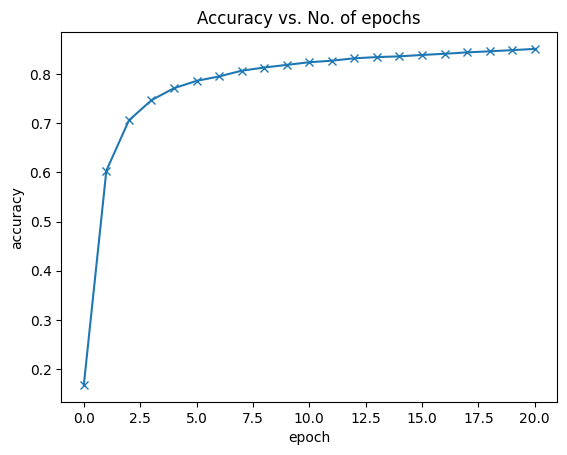

In [207]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with Individual Images

In [208]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


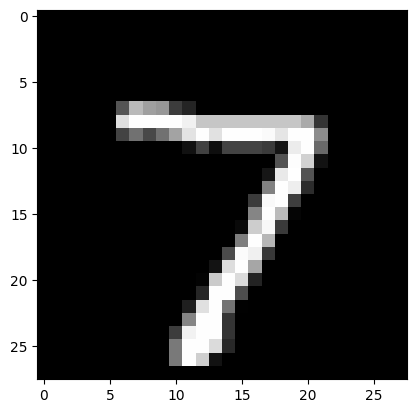

In [209]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [210]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 3 , Predicted: 3


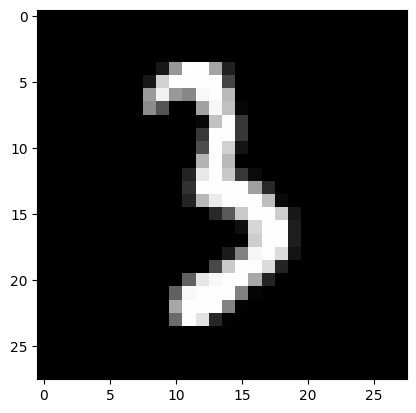

In [211]:
img, label = test_dataset[44]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


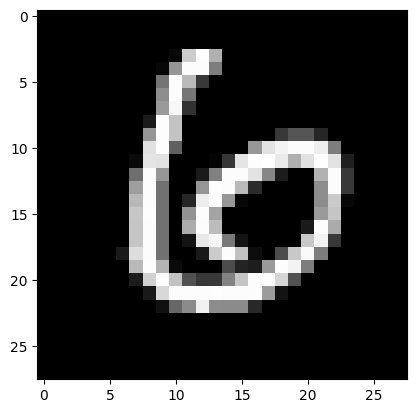

In [212]:
img, label = test_dataset[11]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 7 , Predicted: 4


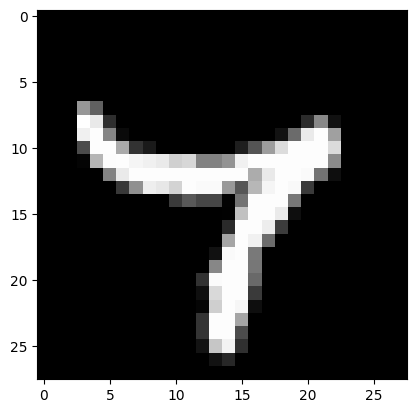

In [213]:
img, label = test_dataset[124]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [214]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6425623297691345, 'val_acc': 0.85888671875}

## Saving and Loading the Model


In [215]:
torch.save(model.state_dict(), 'mnist-model.pth')

In [216]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0281, -0.0143,  0.0037,  ...,  0.0040, -0.0152,  0.0169],
                      [-0.0038, -0.0328,  0.0319,  ..., -0.0190, -0.0112, -0.0351],
                      [ 0.0056,  0.0182, -0.0016,  ..., -0.0250, -0.0021,  0.0137],
                      ...,
                      [ 0.0111, -0.0150, -0.0035,  ...,  0.0197, -0.0055, -0.0066],
                      [ 0.0347,  0.0044,  0.0143,  ..., -0.0124, -0.0041,  0.0032],
                      [-0.0148,  0.0096, -0.0296,  ..., -0.0094, -0.0242, -0.0082]])),
             ('linear.bias',
              tensor([-0.0152,  0.0998, -0.0542, -0.0509,  0.0009,  0.0318,  0.0161,  0.0718,
                      -0.0572,  0.0030]))])

In [217]:
model2 = MnistModel()

In [218]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 1.4388e-02,  3.5237e-02,  5.9239e-03,  ..., -1.8340e-02,
                       -2.1041e-02,  2.6971e-02],
                      [-2.7222e-02,  2.7803e-02, -5.5654e-05,  ..., -8.5334e-03,
                        1.7937e-02,  2.7063e-02],
                      [-1.6248e-02,  2.3574e-02,  9.4878e-03,  ...,  1.0742e-02,
                       -1.5275e-02,  2.3074e-02],
                      ...,
                      [-1.6135e-02,  1.7358e-02, -1.2234e-02,  ..., -1.2848e-02,
                       -4.1087e-03, -3.4514e-02],
                      [ 3.0545e-02, -1.7415e-02, -6.3492e-03,  ..., -2.0264e-02,
                       -8.9336e-03,  1.3030e-02],
                      [-2.0865e-02,  1.0325e-02,  1.8254e-02,  ..., -1.5605e-02,
                       -5.5930e-03,  1.0761e-02]])),
             ('linear.bias',
              tensor([ 0.0168,  0.0350, -0.0270,  0.0332, -0.0321,  0.0195, -0.0171, -0.0275,
                       0.0067,

In [219]:
evaluate(model2, test_loader)

{'val_loss': 2.311445713043213, 'val_acc': 0.10927734524011612}

In [220]:
model2.load_state_dict(torch.load('mnist-model.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0281, -0.0143,  0.0037,  ...,  0.0040, -0.0152,  0.0169],
                      [-0.0038, -0.0328,  0.0319,  ..., -0.0190, -0.0112, -0.0351],
                      [ 0.0056,  0.0182, -0.0016,  ..., -0.0250, -0.0021,  0.0137],
                      ...,
                      [ 0.0111, -0.0150, -0.0035,  ...,  0.0197, -0.0055, -0.0066],
                      [ 0.0347,  0.0044,  0.0143,  ..., -0.0124, -0.0041,  0.0032],
                      [-0.0148,  0.0096, -0.0296,  ..., -0.0094, -0.0242, -0.0082]])),
             ('linear.bias',
              tensor([-0.0152,  0.0998, -0.0542, -0.0509,  0.0009,  0.0318,  0.0161,  0.0718,
                      -0.0572,  0.0030]))])

In [221]:
## Verifying the loaded Model

test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6425623297691345, 'val_acc': 0.85888671875}

## The End